### Import

In [2]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from lightgbm import LGBMClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [3]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [4]:
#creating an objective function
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgb = LGBMClassifier(seed=20, **param)
    lgb.fit(X_train, y_train)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = recall_score(y_valid, y_pred)
    return recall

In [5]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : objective(trial) ,n_trials=50)
print("Number of finished trials: ", len(study.trials))

[LightGBM] [Warning] feature_fraction is set=0.9430655670441366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9430655670441366
[LightGBM] [Warning] lambda_l1 is set=1.1014857178163127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1014857178163127
[LightGBM] [Warning] bagging_fraction is set=0.4999816353074159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4999816353074159
[LightGBM] [Warning] lambda_l2 is set=0.0013928291086864008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013928291086864008
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5622778707832673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5622778707832673
[LightGBM] [Warning] lambda_l1 is set=1.3360460362706746e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3360460362706746e-06
[LightGBM] [Warning] ba

[LightGBM] [Warning] feature_fraction is set=0.8660065650950061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8660065650950061
[LightGBM] [Warning] lambda_l1 is set=0.04329378161407312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04329378161407312
[LightGBM] [Warning] bagging_fraction is set=0.6043342822758389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6043342822758389
[LightGBM] [Warning] lambda_l2 is set=9.99626299741692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.99626299741692
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8583374631509518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8583374631509518
[LightGBM] [Warning] lambda_l1 is set=0.1360504734844752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1360504734844752
[LightGBM] [Warning] bagging_fraction i

[LightGBM] [Warning] feature_fraction is set=0.7396800616631144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7396800616631144
[LightGBM] [Warning] lambda_l1 is set=1.0525430960163013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0525430960163013e-05
[LightGBM] [Warning] bagging_fraction is set=0.8765075528450627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8765075528450627
[LightGBM] [Warning] lambda_l2 is set=4.4566387521312145e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4566387521312145e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9148253203527541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9148253203527541
[LightGBM] [Warning] lambda_l1 is set=0.0005625448854964995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005625448854964995
[LightGBM] [War

[LightGBM] [Warning] feature_fraction is set=0.9703814469329587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9703814469329587
[LightGBM] [Warning] lambda_l1 is set=8.111527666371067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.111527666371067
[LightGBM] [Warning] bagging_fraction is set=0.7504187155189816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504187155189816
[LightGBM] [Warning] lambda_l2 is set=1.1986044573220174e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1986044573220174e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9739415429204582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9739415429204582
[LightGBM] [Warning] lambda_l1 is set=2.6633942688178747e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6633942688178747e-08
[LightGBM] [Warning] ba

Number of finished trials:  50


In [6]:
#view the best hyperparameters
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 34
	params: {'lambda_l1': 7.500434316425264, 'lambda_l2': 1.4878687807214843e-06, 'num_leaves': 3, 'feature_fraction': 0.8925945108557979, 'bagging_fraction': 0.8405430656969445, 'bagging_freq': 2, 'min_child_samples': 11}
	values: [0.7089552238805971]


In [7]:
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]


[LightGBM] [Warning] feature_fraction is set=0.8925945108557979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8925945108557979
[LightGBM] [Warning] lambda_l1 is set=7.500434316425264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.500434316425264
[LightGBM] [Warning] bagging_fraction is set=0.8405430656969445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8405430656969445
[LightGBM] [Warning] lambda_l2 is set=1.4878687807214843e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4878687807214843e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [8]:

# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.108
Accuracy: 0.636
Recall: 0.709
F1: 0.187
Fbeta: 0.335
ROC AUC: 0.670
PR AUC: 0.094


<AxesSubplot:title={'center':'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

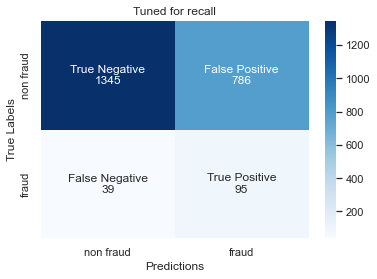

In [9]:
get_confusion_matrix(y_valid, y_pred, "Tuned for recall")

#### Finding hyperparameter with the best f2 score

In [10]:
#creating an objective function
def objective(trial):

    #hyperparameters to tune
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    #creating the model
    lgb = LGBMClassifier(seed = 20, **param)
    lgb.fit(X_train, y_train)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    fbeta = fbeta_score(y_valid, y_pred, beta = 2)
    return fbeta

In [11]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study2.trials))

[LightGBM] [Warning] feature_fraction is set=0.4035863394672706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4035863394672706
[LightGBM] [Warning] lambda_l1 is set=0.002981158968011357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002981158968011357
[LightGBM] [Warning] bagging_fraction is set=0.6152650723390604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6152650723390604
[LightGBM] [Warning] lambda_l2 is set=0.16346023376343585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16346023376343585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5365754833752371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365754833752371
[LightGBM] [Warning] lambda_l1 is set=0.00036527877335990804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036527877335990804
[LightGBM] [Warning] ba

[LightGBM] [Warning] feature_fraction is set=0.8781262680005556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781262680005556
[LightGBM] [Warning] lambda_l1 is set=1.3982012600034973e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3982012600034973e-08
[LightGBM] [Warning] bagging_fraction is set=0.5748131355663706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5748131355663706
[LightGBM] [Warning] lambda_l2 is set=8.3443721057387e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.3443721057387e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9921242068826267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9921242068826267
[LightGBM] [Warning] lambda_l1 is set=0.5873428998121882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5873428998121882
[LightGBM] [Warning] baggin

[LightGBM] [Warning] feature_fraction is set=0.853405510350995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.853405510350995
[LightGBM] [Warning] lambda_l1 is set=0.004632947804109163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004632947804109163
[LightGBM] [Warning] bagging_fraction is set=0.4615316951366132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4615316951366132
[LightGBM] [Warning] lambda_l2 is set=1.0349790551781345e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0349790551781345e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9463334507465886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9463334507465886
[LightGBM] [Warning] lambda_l1 is set=1.0365229236069189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0365229236069189
[LightGBM] [Warning] baggin

[LightGBM] [Warning] feature_fraction is set=0.9659844887274232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9659844887274232
[LightGBM] [Warning] lambda_l1 is set=8.602416029790382e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602416029790382e-05
[LightGBM] [Warning] bagging_fraction is set=0.7455252979898255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7455252979898255
[LightGBM] [Warning] lambda_l2 is set=1.1344938716069224e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1344938716069224e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9205333537821342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205333537821342
[LightGBM] [Warning] lambda_l1 is set=0.8160281422192484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8160281422192484
[LightGBM] [Warning] ba

[LightGBM] [Warning] feature_fraction is set=0.8605273774563028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8605273774563028
[LightGBM] [Warning] lambda_l1 is set=3.1413738726086464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1413738726086464
[LightGBM] [Warning] bagging_fraction is set=0.5083640687515892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5083640687515892
[LightGBM] [Warning] lambda_l2 is set=8.077568805592903e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.077568805592903e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9404172815824845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9404172815824845
[LightGBM] [Warning] lambda_l1 is set=0.001774932618919724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001774932618919724
[LightGBM] [Warning] baggin

[LightGBM] [Warning] feature_fraction is set=0.7546506538734042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546506538734042
[LightGBM] [Warning] lambda_l1 is set=4.770502036883881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.770502036883881
[LightGBM] [Warning] bagging_fraction is set=0.5555229000636129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555229000636129
[LightGBM] [Warning] lambda_l2 is set=9.205018267654323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.205018267654323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9755561922061956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9755561922061956
[LightGBM] [Warning] lambda_l1 is set=2.394307170923094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.394307170923094
[LightGBM] [Warning] bagging_fracti

[LightGBM] [Warning] feature_fraction is set=0.9791703447034963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9791703447034963
[LightGBM] [Warning] lambda_l1 is set=2.197989365303957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197989365303957
[LightGBM] [Warning] bagging_fraction is set=0.5983888150850519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5983888150850519
[LightGBM] [Warning] lambda_l2 is set=0.008527689261975311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008527689261975311
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9693891197031964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693891197031964
[LightGBM] [Warning] lambda_l1 is set=1.4024735585920676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4024735585920676
[LightGBM] [Warning] bagging_fracti

[LightGBM] [Warning] feature_fraction is set=0.9494723262626615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9494723262626615
[LightGBM] [Warning] lambda_l1 is set=0.5488087992349999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5488087992349999
[LightGBM] [Warning] bagging_fraction is set=0.5686721303657103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5686721303657103
[LightGBM] [Warning] lambda_l2 is set=0.03454888204011652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03454888204011652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9995090750784609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995090750784609
[LightGBM] [Warning] lambda_l1 is set=5.450985148398723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.450985148398723
[LightGBM] [Warning] bagging_fraction

[LightGBM] [Warning] feature_fraction is set=0.4655869398846186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4655869398846186
[LightGBM] [Warning] lambda_l1 is set=3.7038166514186446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7038166514186446
[LightGBM] [Warning] bagging_fraction is set=0.6085842646208497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6085842646208497
[LightGBM] [Warning] lambda_l2 is set=0.015910453074927052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015910453074927052
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Number of finished trials:  100


In [12]:
#view the best hyperparameters
trial = study2.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 61
	params: {'lambda_l1': 2.394307170923094, 'lambda_l2': 3.002442821229809e-05, 'num_leaves': 229, 'feature_fraction': 0.9755561922061956, 'bagging_fraction': 0.5080219114367626, 'bagging_freq': 2, 'min_child_samples': 22}
	values: [0.41578947368421054]


In [13]:
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]


[LightGBM] [Warning] feature_fraction is set=0.9755561922061956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9755561922061956
[LightGBM] [Warning] lambda_l1 is set=2.394307170923094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.394307170923094
[LightGBM] [Warning] bagging_fraction is set=0.5080219114367626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5080219114367626
[LightGBM] [Warning] lambda_l2 is set=3.002442821229809e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.002442821229809e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [14]:
# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.191
Accuracy: 0.828
Recall: 0.590
F1: 0.288
Fbeta: 0.416
ROC AUC: 0.716
PR AUC: 0.137


<AxesSubplot:title={'center':'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

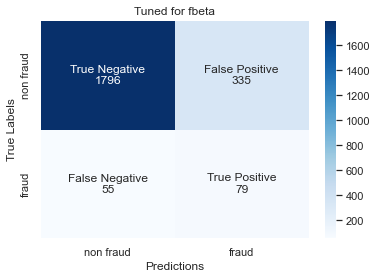

In [15]:
#Confusion Matrix
get_confusion_matrix(y_valid, y_pred, "Tuned for fbeta")

#### Making predictions on test set

In [16]:
y_pred = test.predict(X_test)
predictions = [round(value) for value in y_pred]

In [17]:
get_scores(y_test, predictions)

Precision: 0.179
Accuracy: 0.840
Recall: 0.478
F1: 0.261
Fbeta: 0.358
ROC AUC: 0.670
PR AUC: 0.117


<AxesSubplot:title={'center':'Test set results'}, xlabel='Predictions', ylabel='True Labels'>

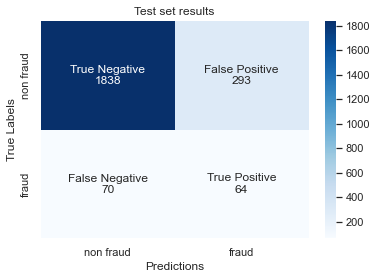

In [18]:
#Confusion Matrix
get_confusion_matrix(y_test, y_pred, "Test set results")

### SHAP

In [19]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [20]:
X_display = df_train.drop('FraudFound_P', axis=1)

In [21]:
explainer = shap.TreeExplainer(test)
shap_values = explainer.shap_values(X_train[1:1000,:])

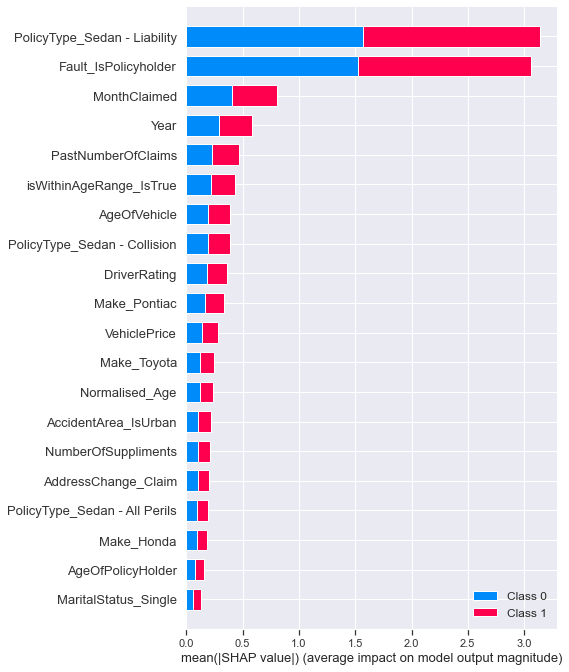

In [22]:
#featuere importance
shap.summary_plot(shap_values, X_train[1:1000,:], feature_names=features, plot_type="bar")